<a href="https://colab.research.google.com/github/z-tufekci/DeepLearning/blob/main/FinRL_OneStock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INSTALL FinRL Pack and IMPORT libs

## Install Packages

In [ ]:
!pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

In [ ]:
!pip install git+https://github.com/AI4Finance-Foundation/FinRL-Meta.git

## Import FinRL libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.apps import config

from finrl.finrl_meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.finrl_meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent # Deep Reinforcement Learning Agent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


## Import Stock time series and Technical Indicators

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


DOW30 STOCKS BETWEEN 2000-2016 TRAINING / 2016-2020 TRADING

In [6]:
#del df
filenames = ['AAPL']
df_temps = []
for fn in filenames :
    df_temp = pd.read_csv('gdrive/My Drive/DeepLearning/'+fn+'.csv', sep=';')
    df_temp = df_temp.iloc[33:, 0:9]
    df_temp['tic'] = fn
    df_temps.append(df_temp)
df = pd.concat(df_temps, ignore_index=True)


In [7]:
df_baseline = get_baseline(ticker='AAPL', start='2016-09-15', end='2020-09-04') # ^DJI
stats = backtest_stats(df_baseline, value_col_name = 'close')

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1000, 8)
Annual return          0.455316
Cumulative returns     3.432574
Annual volatility      0.302022
Sharpe ratio           1.395617
Calmar ratio           1.182151
Stability              0.844736
Max drawdown          -0.385159
Omega ratio            1.311865
Sortino ratio          2.070484
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.102635
Daily value at risk   -0.036379
dtype: float64


## PROCESS DATA

In [8]:
print(df.head())
print(df.shape)

         Date     Close          RSI  TNRSI  ...      SO      CCI     PPO   tic
0  20.10.2000  0,348214  32,56857732  90,52  ...   10,59   -53,88  -33,36  AAPL
1  23.10.2000  0,363839  42,28833544   88,3  ...   30,67   -46,95  -32,46  AAPL
2  24.10.2000  0,337054  31,37251457  75,88  ...   -1,33   -63,41  -31,95  AAPL
3  25.10.2000  0,330357  34,59452129  67,97  ...  -11,32   -77,68  -31,44  AAPL
4  26.10.2000  0,330357  33,87974931  55,76  ...       0  -108,46  -30,79  AAPL

[5 rows x 10 columns]
(4999, 10)


CHANGE TO DATETIME OBJECT

In [9]:
from datetime import datetime
df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x, "%d.%m.%Y") )
df.head()

,Date,Close,RSI,TNRSI,BB PERCENT,ROC-14,SO,CCI,PPO,tic
0,2000-10-20,"0,348214","32,56857732","90,52","34,32520531","-19,5877479","10,59","-53,88","-33,36",AAPL
1,2000-10-23,"0,363839","42,28833544","88,3","37,90456608","-8,683659691","30,67","-46,95","-32,46",AAPL
2,2000-10-24,"0,337054","31,37251457","75,88","35,97616928","-20,10571852","-1,33","-63,41","-31,95",AAPL
3,2000-10-25,"0,330357","34,59452129","67,97","36,07471499","-16,14729943","-11,32","-77,68","-31,44",AAPL
4,2000-10-26,"0,330357","33,87974931","55,76","18,07877184","-16,61967921",0,"-108,46","-30,79",AAPL


SORT BY DATE

In [10]:
df = df.sort_values(by=['Date','tic'], ignore_index=True)
df.head()

,Date,Close,RSI,TNRSI,BB PERCENT,ROC-14,SO,CCI,PPO,tic
0,2000-10-20,"0,348214","32,56857732","90,52","34,32520531","-19,5877479","10,59","-53,88","-33,36",AAPL
1,2000-10-23,"0,363839","42,28833544","88,3","37,90456608","-8,683659691","30,67","-46,95","-32,46",AAPL
2,2000-10-24,"0,337054","31,37251457","75,88","35,97616928","-20,10571852","-1,33","-63,41","-31,95",AAPL
3,2000-10-25,"0,330357","34,59452129","67,97","36,07471499","-16,14729943","-11,32","-77,68","-31,44",AAPL
4,2000-10-26,"0,330357","33,87974931","55,76","18,07877184","-16,61967921",0,"-108,46","-30,79",AAPL


In [11]:
df.rename(columns={'Close': 'close'}, inplace=True)
df.rename(columns={'Date': 'date'}, inplace=True)
df['close'] = df['close'].apply(lambda x: float(x.replace(",", ".")))
df['RSI'] = df['RSI'].apply(lambda x: float(x.replace(",", ".")))
df['TNRSI'] = df['TNRSI'].apply(lambda x: float(x.replace(",", ".")))
df['BB PERCENT'] = df['BB PERCENT'].apply(lambda x: float(x.replace(",", ".")))
df['ROC-14'] = df['ROC-14'].apply(lambda x: float(x.replace(",", ".")))
df['SO'] = df['SO'].apply(lambda x: float(x.replace(",", ".")))
df['PPO'] = df['PPO'].apply(lambda x: float(x.replace(",", ".")))
df['CCI'] = df['CCI'].apply(lambda x: float(x.replace(",", ".")))
df.head()

,date,close,RSI,TNRSI,BB PERCENT,ROC-14,SO,CCI,PPO,tic
0,2000-10-20,0.348214,32.568577,90.52,34.325205,-19.587748,10.59,-53.88,-33.36,AAPL
1,2000-10-23,0.363839,42.288335,88.30,37.904566,-8.683660,30.67,-46.95,-32.46,AAPL
2,2000-10-24,0.337054,31.372515,75.88,35.976169,-20.105719,-1.33,-63.41,-31.95,AAPL
3,2000-10-25,0.330357,34.594521,67.97,36.074715,-16.147299,-11.32,-77.68,-31.44,AAPL
4,2000-10-26,0.330357,33.879749,55.76,18.078772,-16.619679,0.00,-108.46,-30.79,AAPL


SPLIT DATA AS TRAIN AND TEST

In [12]:
#TRAIN
training = data_split(df, '2000-10-20','2016-09-15')
print(training.shape)
#TEST
trading = data_split(df, '2016-09-15','2020-09-04')
print(trading.shape)

(3999, 10)
(1000, 10)


## Action Space and State Space
Normally, Three are 3 actions: {-1, 0, 1}, where 
*   Selling one share = -1
*   Holding one share = 0
*   Buying one share = 1

Also, It can be represented for multiple shares. 
An action space: {-k,…,-1, 0, 1, …, k}
*   the number of shares to buy = k
*   the number of shares to sell= -k 

For example, 
* Buy 10 shares of AAPL = 10
* Sell 10 shares of AAPL = -10 

In [13]:
ratio_list = ['RSI','TNRSI','BB PERCENT','ROC-14','SO','CCI','PPO'] # Technical Indicator List
stock_dimension = len(training.tic.unique()) # IT CAN BE ONE STOCK OR MULTIPLE STOCKS
state_space = 1 + 2*stock_dimension + len(ratio_list)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

# Parameters for the environment
env_kwargs = {
    "hmax": 100, # -100<=K<=100 IT MEANS 100*2+1=201 ACTION SPACE  [1 0 -1]= 3 Act space
    "initial_amount": 100000, 
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space, 
    "stock_dim": stock_dimension, 
    "tech_indicator_list": ratio_list, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4
   
}
#Establish the training environment using StockTradingEnv() class
e_train_gym = StockTradingEnv(df = training, **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()


Stock Dimension: 1, State Space: 10


# MODEL1: ⚽ Advantage Actor Critic (A2C) 


In [23]:
agent = DRLAgent(env = env_train)

In [24]:
model_a2c = agent.get_model("a2c")

{'n_steps': 5, 'ent_coef': 0.01, 'learning_rate': 0.0007}
Using cpu device


In [25]:
trained_a2c = agent.train_model(model=model_a2c, 
                             tb_log_name='a2c',
                             total_timesteps=50000)

--------------------------------------
| time/                 |            |
|    fps                | 356        |
|    iterations         | 100        |
|    time_elapsed       | 1          |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -1.56      |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | 0.000486   |
|    reward             | 1.6204e-05 |
|    std                | 1.15       |
|    value_loss         | 4.59e-08   |
--------------------------------------
----------------------------------------
| time/                 |              |
|    fps                | 364          |
|    iterations         | 200          |
|    time_elapsed       | 2            |
|    total_timesteps    | 1000         |
| train/                |              |
|    entropy_loss       | -1.64        |
|    explained_variance | -1.19e-07    |
|    le

## TEST Advantage Actor Critic (A2C)

In [26]:
e_trade_gym = StockTradingEnv(df = trading, **env_kwargs)
df_account_value_a2c, df_actions = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym)

hit end!


In [27]:
print(df_account_value_a2c.shape)
df_account_value_a2c.tail()

(1000, 2)


,date,account_value
995,2020-08-28,437431.038250
996,2020-08-31,452261.683210
997,2020-09-01,470272.243210
998,2020-09-02,460531.126714
999,2020-09-03,423669.057226


In [28]:
df_actions

,date,actions
0,2016-09-15,[100]
1,2016-09-16,[100]
2,2016-09-19,[100]
3,2016-09-20,[100]
4,2016-09-21,[100]
...,...,...
994,2020-08-27,[0]
995,2020-08-28,[0]
996,2020-08-31,[0]
997,2020-09-01,[0]


# MODEL 2: ⛽ Deep Deterministic Policy Gradient (DDPG)

In [ ]:
agent = DRLAgent(env = env_train)
model_ddpg = agent.get_model("ddpg")

In [ ]:
trained_ddpg = agent.train_model(model=model_ddpg, 
                             tb_log_name='ddpg',
                             total_timesteps=50000)

## TEST Deep Deterministic Policy Gradient (DDPG)

In [16]:
e_trade_gym = StockTradingEnv(df = trading, **env_kwargs)
df_account_value_ddpg, df_actions = DRLAgent.DRL_prediction(
    model=trained_ddpg, 
    environment = e_trade_gym)

hit end!


In [17]:
print(df_account_value_ddpg.shape)
df_account_value_ddpg.tail()

(1000, 2)


,date,account_value
995,2020-08-28,100000.0
996,2020-08-31,100000.0
997,2020-09-01,100000.0
998,2020-09-02,100000.0
999,2020-09-03,100000.0


In [18]:
df_actions

,date,actions
0,2016-09-15,[0]
1,2016-09-16,[0]
2,2016-09-19,[0]
3,2016-09-20,[0]
4,2016-09-21,[0]
...,...,...
994,2020-08-27,[0]
995,2020-08-28,[0]
996,2020-08-31,[0]
997,2020-09-01,[0]


# MODEL3: ❎ Proximal Policy Optimization (PPO) 

In [ ]:
agent = DRLAgent(env = env_train)
PPO_PARAMS = {
    "n_steps": 2048,
    "ent_coef": 0.01,
    "learning_rate": 0.00025,
    "batch_size": 128,
}
model_ppo = agent.get_model("ppo",model_kwargs = PPO_PARAMS)

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.00025, 'batch_size': 128}
Using cuda device


In [ ]:
trained_ppo = agent.train_model(model=model_ppo, 
                             tb_log_name='ppo',
                             total_timesteps=50000)

-------------------------------------
| time/              |              |
|    fps             | 312          |
|    iterations      | 1            |
|    time_elapsed    | 6            |
|    total_timesteps | 2048         |
| train/             |              |
|    reward          | -0.015420608 |
-------------------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 288          |
|    iterations           | 2            |
|    time_elapsed         | 14           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0023018974 |
|    clip_fraction        | 0.014        |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.42        |
|    explained_variance   | -0.955       |
|    learning_rate        | 0.00025      |
|    loss                 | -0.0165      |
|    n_updates            | 10           |
|    policy_g

## TEST Proximal Policy Optimization (PPO)

In [ ]:
e_trade_gym = StockTradingEnv(df = trading, **env_kwargs)
df_account_value_ppo, df_actions = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym)

hit end!


In [ ]:
print(df_account_value_ppo.shape)
df_account_value_ppo.tail()

(1000, 2)


,date,account_value
995,2020-08-28,421385.871649
996,2020-08-31,434867.714216
997,2020-09-01,451699.751577
998,2020-09-02,442330.332924
999,2020-09-03,407958.882722


In [ ]:
df_actions

          date actions
0   2016-09-15     [4]
1   2016-09-16    [53]
2   2016-09-19    [49]
3   2016-09-20   [100]
4   2016-09-21    [19]
..         ...     ...
994 2020-08-27     [0]
995 2020-08-28   [-22]
996 2020-08-31  [-100]
997 2020-09-01    [91]
998 2020-09-02    [-4]

[999 rows x 2 columns]


# MODEL4: ⛄ Twin-Delayed Deep Deterministic Policy Gradient Agents (TD3)

In [ ]:
agent = DRLAgent(env = env_train)
TD3_PARAMS = {"batch_size": 100, 
              "buffer_size": 1000000, 
              "learning_rate": 0.001}

model_td3 = agent.get_model("td3",model_kwargs = TD3_PARAMS)

{'batch_size': 100, 'buffer_size': 1000000, 'learning_rate': 0.001}
Using cuda device


In [ ]:
trained_td3 = agent.train_model(model=model_td3, 
                             tb_log_name='td3',
                             total_timesteps=50000)

day: 3998, episode: 30
begin_total_asset: 100000.00
end_total_asset: 3771930.00
total_reward: 3671930.00
total_cost: 99.90
total_trades: 3998
Sharpe: 0.924
---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 103      |
|    time_elapsed    | 154      |
|    total_timesteps | 15996    |
| train/             |          |
|    actor_loss      | 47.5     |
|    critic_loss     | 841      |
|    learning_rate   | 0.001    |
|    n_updates       | 11997    |
|    reward          | 12.89145 |
---------------------------------
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 91       |
|    time_elapsed    | 348      |
|    total_timesteps | 31992    |
| train/             |          |
|    actor_loss      | 318      |
|    critic_loss     | 309      |
|    learning_rate   | 0.001    |
|    n_updates       | 27993    |
|    reward          | 12.89

## TEST Twin-Delayed Deep Deterministic Policy Gradient Agents (TD3)

In [ ]:
e_trade_gym = StockTradingEnv(df = trading, **env_kwargs)
df_account_value_td3, df_actions = DRLAgent.DRL_prediction(
    model=trained_td3, 
    environment = e_trade_gym)

hit end!


In [ ]:
print(df_account_value_td3.shape)
df_account_value_td3.tail()

(1000, 2)


,date,account_value
995,2020-08-28,434470.085577
996,2020-08-31,449203.383267
997,2020-09-01,467095.723267
998,2020-09-02,457418.546748
999,2020-09-03,420798.437191


# MODEL 5: ⏲ Soft Actor-Critic (SAC)

In [ ]:
agent = DRLAgent(env = env_train)
SAC_PARAMS = {
    "batch_size": 128,
    "buffer_size": 1000000,
    "learning_rate": 0.001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

model_sac = agent.get_model("sac",model_kwargs = SAC_PARAMS)

{'batch_size': 128, 'buffer_size': 1000000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device


In [ ]:
trained_sac = agent.train_model(model=model_sac, 
                             tb_log_name='sac',
                             total_timesteps=50000)

---------------------------------
| time/              |          |
|    episodes        | 4        |
|    fps             | 49       |
|    time_elapsed    | 322      |
|    total_timesteps | 15996    |
| train/             |          |
|    actor_loss      | -583     |
|    critic_loss     | 252      |
|    ent_coef        | 0.49     |
|    ent_coef_loss   | 22.8     |
|    learning_rate   | 0.0001   |
|    n_updates       | 15895    |
|    reward          | 0.0      |
---------------------------------
day: 3998, episode: 50
begin_total_asset: 100000.00
end_total_asset: 100000.00
total_reward: 0.00
total_cost: 0.00
total_trades: 0
---------------------------------
| time/              |          |
|    episodes        | 8        |
|    fps             | 48       |
|    time_elapsed    | 660      |
|    total_timesteps | 31992    |
| train/             |          |
|    actor_loss      | 2.28e+03 |
|    critic_loss     | 5.56     |
|    ent_coef        | 2.43     |
|    ent_coef_loss 

## TEST Soft Actor-Critic (SAC)

In [ ]:
e_trade_gym = StockTradingEnv(df = trading, **env_kwargs)
df_account_value_sac, df_actions = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym)

hit end!


In [ ]:
print(df_account_value_sac.shape)
df_account_value_sac.tail()

(1000, 2)


,date,account_value
995,2020-08-28,100000.0
996,2020-08-31,100000.0
997,2020-09-01,100000.0
998,2020-09-02,100000.0
999,2020-09-03,100000.0


# Back Test Plot

In [29]:
print("==============Get Backtest Results===========")
perf_stats_all = backtest_stats(account_value=df_account_value_a2c)
perf_stats_all = pd.DataFrame(perf_stats_all)
print("==============Get Baseline Results===========")
df_baseline = get_baseline(ticker='AAPL', start='2016-09-15', end='2020-09-04') # ^DJI
stats = backtest_stats(df_baseline, value_col_name = 'close')
stats = pd.DataFrame(stats)

==============Get Backtest Results===========
Annual return          0.438834
Cumulative returns     3.236691
Annual volatility      0.301245
Sharpe ratio           1.360534
Calmar ratio           1.133600
Stability              0.828734
Max drawdown          -0.387116
Omega ratio            1.305560
Sortino ratio          2.017489
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.102400
Daily value at risk   -0.036327
dtype: float64
==============Get Baseline Results===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1000, 8)
Annual return          0.455316
Cumulative returns     3.432574
Annual volatility      0.302022
Sharpe ratio           1.395617
Calmar ratio           1.182150
Stability              0.844736
Max drawdown          -0.385159
Omega ratio            1.311866
Sortino ratio          2.070484
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.

In [30]:
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

In [31]:
backtest_plot(df_account_value_a2c, 
             baseline_ticker = 'AAPL', 
             baseline_start = '2016-09-15',
             baseline_end = '2020-09-04') 

[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1000, 8)


Start date,2016-09-15
End date,2020-09-03
Total months,47
,Backtest
Annual return,43.883%
Cumulative returns,323.669%
Annual volatility,30.124%
Sharpe ratio,1.36
Calmar ratio,1.13
Stability,0.83
Max drawdown,-38.712%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,38.71,2018-10-03,2019-01-03,2019-10-11,268
1,31.38,2020-02-12,2020-03-23,2020-06-05,83
2,13.45,2018-01-18,2018-02-08,2018-03-09,37
3,10.69,2018-03-12,2018-04-27,2018-05-04,40
4,9.91,2020-09-01,2020-09-03,NaT,NaN


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


==============Compare to baseline buy-and-hold===========


Start date,2016-09-15
End date,2020-09-03
Total months,47
,Backtest
Annual return,43.883%
Cumulative returns,323.669%
Annual volatility,30.124%
Sharpe ratio,1.36
Calmar ratio,1.13
Stability,0.83
Max drawdown,-38.712%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,38.71,2018-10-03,2019-01-03,2019-10-11,268
1,31.38,2020-02-12,2020-03-23,2020-06-05,83
2,13.45,2018-01-18,2018-02-08,2018-03-09,37
3,10.69,2018-03-12,2018-04-27,2018-05-04,40
4,9.91,2020-09-01,2020-09-03,NaT,NaN


/usr/local/lib/python3.7/dist-packages/pyfolio/tears.py:907: UserWarning: Passed returns do not overlap with anyinteresting times.
  'interesting times.', UserWarning)


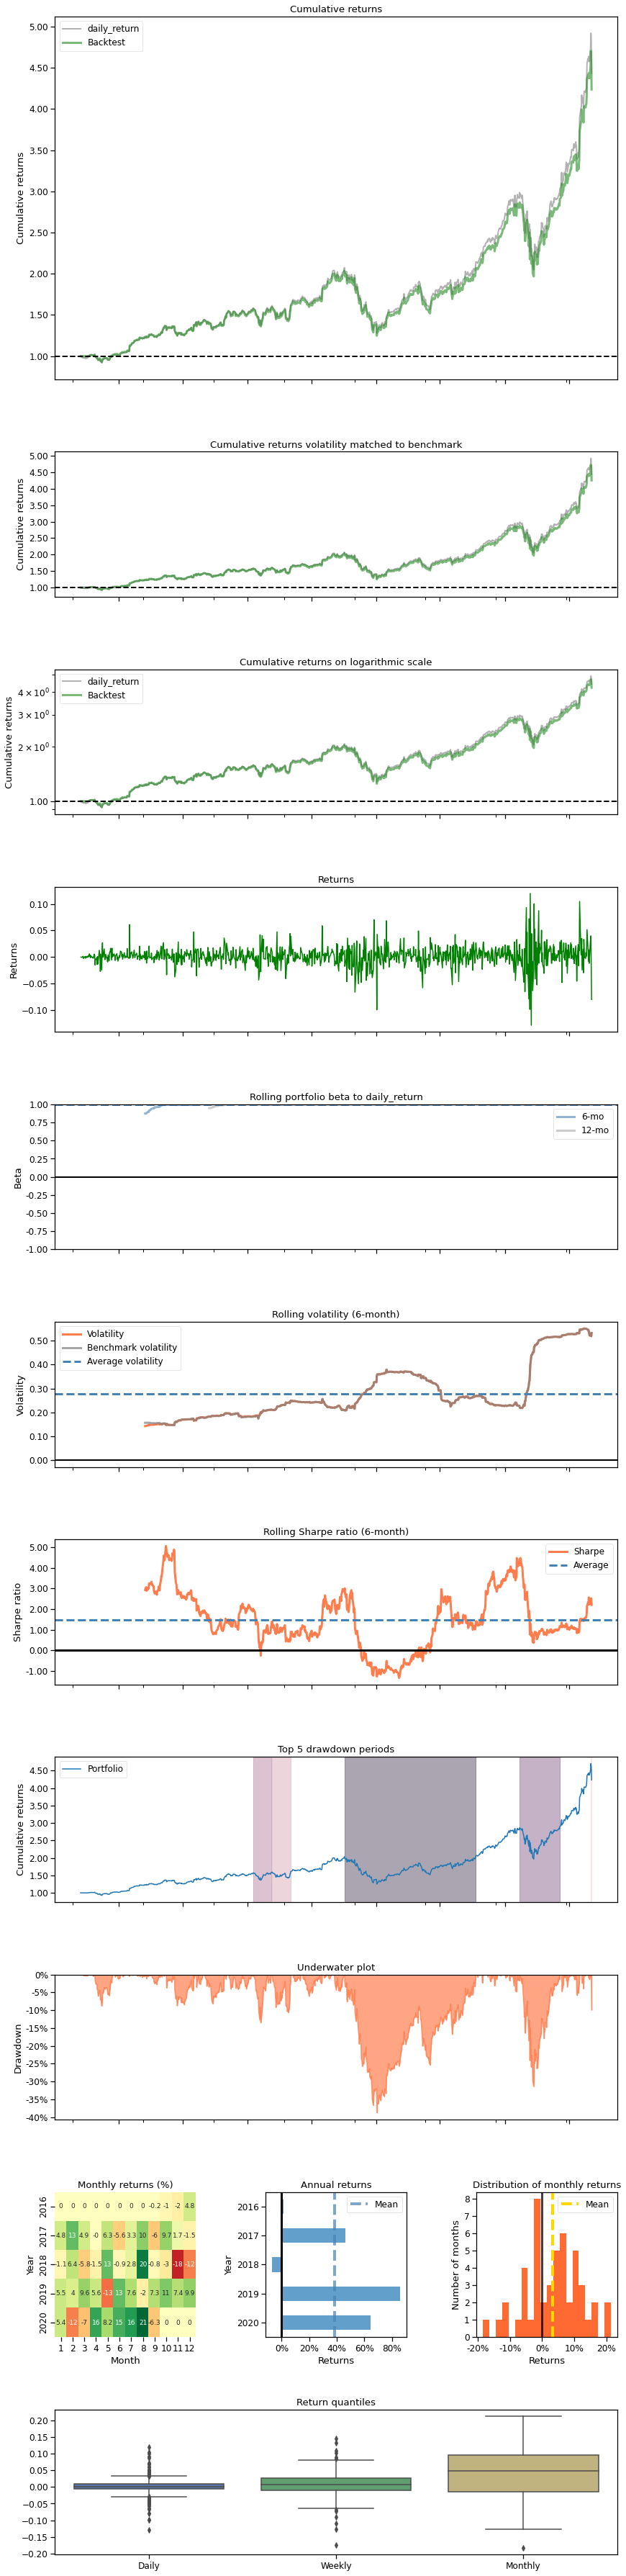

In [32]:
import pyfolio
def backtest_plot():
    baseline_returns = get_daily_return(df_baseline, value_col_name="close") # This is current daily return 
    test_returns = get_daily_return(df_account_value_a2c) # This is our offering strategy
    with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(
            returns=test_returns, benchmark_rets=baseline_returns, set_context=False
        )
print("==============Compare to baseline buy-and-hold===========")
%matplotlib inline
backtest_plot()